# Predicting Store Stockloss for 2023

The aim here is to predict store stockloss using a linear regression model. The model will be tested on 2022 sales and loss data, but also account for store features such as their location, size, etc. It should be noted that I am using Loss Per Week (LPW) measures instead of actual loss and sales because I want to use more normalised measures for the data and reduce the range of values. 

Note that for Stockloss, I am looking at cost value, not retail value. I am interested in prediciting how much it will actually cost the business. 

The first step is to import all the relevant libraries. 

# Importing the data and preparing it for analysis

In [1]:
# For manipulating and organising the data:

import pandas as pd 
import numpy as np 

# For plotting visualisations:

import seaborn as sns #prettier visualisations
import matplotlib.pyplot as plt #plotting graphs
%matplotlib inline #sets the graphs to appear as output without having to specify 'show' 

#For building the model. I'm importing two because I want to compare the performance
# As I am using supervised machine learning, I'm importing the train test split library 
# So that the model can be evaluated on data it hasn't seen before

import statsmodels.api as sm # Model building tool (1) simple regression model tool
from sklearn.linear_model import LinearRegression # Model building tool (2) more robust regression tool
from sklearn.model_selection import train_test_split 

UsageError: unrecognized arguments: #sets the graphs to appear as output without having to specify 'show'


Importing the data which was obtaining from a SQL script in snowflake

In [ ]:
df = pd.read_csv('Data - Finalised Data.csv')

In [4]:
df.head()

,StoreNumber,LLY_LPW_COST,LLY_LPW_SALES,TY_LPW_COST,TY_LPW_SALES,LOCATION_GEOGRAPHICAL,LOCATION_TYPE_CODE,LOCATION_TYPE,LOCATION_SHOP_CODE,STAFF_HOURS,...,No._of_deliveries,Opening_Hours,SQ_FOOTAGE,GEO_REGION,MARKET,GRADE,SEASIDE_FLAG,SITE_STATUS,UNI_FLAG,VM_CLASS
0,2,-1374.00,133473.22,-992.92,82770.09,Central London,City,High Street,Basement Menswear,43451.82,...,3,69.5,14444,LONDON & GREATER LONDON,London,FS1,N,LFL,N,FLAG
1,3,-1629.83,48039.71,-1298.29,39998.92,Greater London,Town,In Town Shopping Centre,Lower Menswear Own Entrance,22046.34,...,2,62.5,8991,LONDON & GREATER LONDON,London,4,N,LFL,N,MID
2,6,-154.75,29056.48,-203.33,26249.30,North West,Town,In Town Shopping Centre,Rear of Shop Menswear,15403.42,...,2,57.0,6891,THE NORTH,North West,3,N,LFL,N,STANDARD
3,8,-540.85,42601.89,-608.40,38423.83,South East,Seaside,City Shopping Centre,First Floor Menswear,20972.07,...,2,60.0,8079,SOUTH EAST,South East,4,Y,LFL,Y,MID
4,9,-578.31,31399.93,-584.02,31498.97,South,Seaside,High Street,First Floor Menswear,14835.19,...,1,60.0,7392,SOUTH WEST,South West,4,Y,LFL,Y,SMALL


Looking at the overall information of the data, just to check I have all the data that I need and that it is sensical.

In [5]:
df[['TY_LPW_COST','TY_LPW_SALES','STAFF_HOURS','NUMBER_OF_STAFF', 'No._of_Entrances' , 'No._of_Floors', 'No._of_Windows',
    'No._of_Cash_Desks','Escalators', 'No._of_deliveries', 'SQ_FOOTAGE','Opening_Hours']].describe()

,TY_LPW_COST,TY_LPW_SALES,STAFF_HOURS,NUMBER_OF_STAFF,No._of_Entrances,No._of_Floors,No._of_Windows,No._of_Cash_Desks,Escalators,No._of_deliveries,SQ_FOOTAGE,Opening_Hours
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,-434.372308,38168.023725,19455.648462,22.705190,1.137652,1.765182,2.809717,1.773279,0.145749,1.639676,6890.218623,62.631579
std,482.535776,30810.815984,11447.224452,17.109533,0.419639,0.478737,1.209812,0.438510,0.572944,0.659302,3100.195398,5.768739
min,-3175.750000,7560.880000,8923.900000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2064.000000,54.000000
25%,-521.000000,20561.920000,13519.015000,15.181818,1.000000,1.000000,2.000000,2.000000,0.000000,1.000000,4932.500000,57.500000
50%,-274.870000,29441.940000,15518.980000,19.090909,1.000000,2.000000,2.000000,2.000000,0.000000,2.000000,6240.000000,60.000000
75%,-149.160000,41237.060000,20532.420000,25.045455,1.000000,2.000000,3.000000,2.000000,0.000000,2.000000,7739.000000,68.000000
max,-11.490000,189613.710000,70630.240000,95.818182,4.000000,3.000000,9.000000,3.000000,4.000000,5.000000,23154.000000,79.000000


Just checking if there are any nulls in the dataframe.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 26 columns):
StoreNumber              247 non-null int64
LLY_LPW_COST             245 non-null float64
LLY_LPW_SALES            245 non-null float64
TY_LPW_COST              247 non-null float64
TY_LPW_SALES             247 non-null float64
LOCATION_GEOGRAPHICAL    247 non-null object
LOCATION_TYPE_CODE       247 non-null object
LOCATION_TYPE            247 non-null object
LOCATION_SHOP_CODE       247 non-null object
STAFF_HOURS              247 non-null float64
NUMBER_OF_STAFF          247 non-null float64
No._of_Entrances         247 non-null int64
No._of_Floors            247 non-null int64
No._of_Windows           247 non-null int64
No._of_Cash_Desks        247 non-null int64
Escalators               247 non-null int64
No._of_deliveries        247 non-null int64
Opening_Hours            247 non-null float64
SQ_FOOTAGE               247 non-null int64
GEO_REGION               247 non-null obj

In order to continue with the analysis, I need to prepare the data. To do this, I need to assign dummies to the categorical data. This data relates to features of the stores. Such features include their location, if they are new or located by the seaside or in a uni town.

Why is this necessary? 

Because one reason for the level of variation of stockloss is the local crime. Another reason is level of experience in a store which in turn affects response to theft or ability to manage stock in the store. 

In [7]:
df = pd.get_dummies(df,columns = ['LOCATION_GEOGRAPHICAL', 'LOCATION_TYPE_CODE', 'LOCATION_TYPE','LOCATION_SHOP_CODE',
                                  'GEO_REGION', 'MARKET', 'GRADE', 'SEASIDE_FLAG', 'SITE_STATUS', 'UNI_FLAG', 'VM_CLASS'
                                 ],drop_first = False)

By assigning dummy variables, this creates more columns in the dataframe. 

In [8]:
df.columns

Index(['StoreNumber', 'LLY_LPW_COST', 'LLY_LPW_SALES', 'TY_LPW_COST',
       'TY_LPW_SALES', 'STAFF_HOURS', 'NUMBER_OF_STAFF', 'No._of_Entrances',
       'No._of_Floors', 'No._of_Windows',
       ...
       'SITE_STATUS_RESITE', 'UNI_FLAG_N', 'UNI_FLAG_Y', 'VM_CLASS_FLAG',
       'VM_CLASS_LARGE', 'VM_CLASS_MEGA', 'VM_CLASS_MID', 'VM_CLASS_SMALL',
       'VM_CLASS_STANDARD', 'VM_CLASS_X SMALL'],
      dtype='object', length=101)

In [9]:
df[[ 'VM_CLASS_FLAG',
       'VM_CLASS_LARGE', 'VM_CLASS_MEGA', 'VM_CLASS_MID', 'VM_CLASS_SMALL',
       'VM_CLASS_STANDARD', 'VM_CLASS_X SMALL']]

,VM_CLASS_FLAG,VM_CLASS_LARGE,VM_CLASS_MEGA,VM_CLASS_MID,VM_CLASS_SMALL,VM_CLASS_STANDARD,VM_CLASS_X SMALL
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0
5,0,0,0,0,0,0,1
6,0,0,0,0,0,1,0
7,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0
9,0,1,0,0,0,0,0


# Analysing correlations

Using a distribution plot to look at the spread of LPW (cost)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


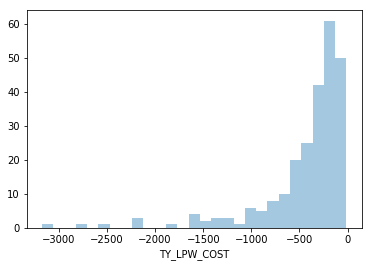

In [11]:
sns.distplot(df['TY_LPW_COST'],kde=False)

Looking at the correlation between cost and sales.

In [12]:
df[['TY_LPW_COST','TY_LPW_SALES']].corr()

,TY_LPW_COST,TY_LPW_SALES
TY_LPW_COST,1.000000,-0.799614
TY_LPW_SALES,-0.799614,1.000000


This matrix shows that there is a strong negative correlation between the two measures. This makes sense. If a store is losing more stock, then they have less to sell or they have to focus more efforts in reducing stockloss rather than boosting sales. 

Now to visualise this using pairplots

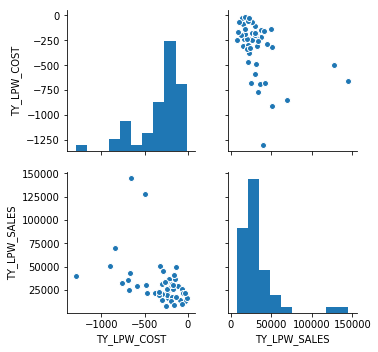

In [13]:
sns.pairplot(df[['TY_LPW_COST','TY_LPW_SALES']].sample(frac=.2) )

This next step is just to get a list of columns for the next step which is too look if there is any correlation between the geographical area in which a store is situated and the LPW cost. 

In [14]:
df.columns[df.columns.str.contains(pat = 'LOCATION_GEOGRAPHICAL')]

Index(['LOCATION_GEOGRAPHICAL_Central London', 'LOCATION_GEOGRAPHICAL_East',
       'LOCATION_GEOGRAPHICAL_East Midlands', 'LOCATION_GEOGRAPHICAL_Eire',
       'LOCATION_GEOGRAPHICAL_Greater London',
       'LOCATION_GEOGRAPHICAL_North East', 'LOCATION_GEOGRAPHICAL_North West',
       'LOCATION_GEOGRAPHICAL_Northern Ireland',
       'LOCATION_GEOGRAPHICAL_Scotland', 'LOCATION_GEOGRAPHICAL_South',
       'LOCATION_GEOGRAPHICAL_South East', 'LOCATION_GEOGRAPHICAL_South West',
       'LOCATION_GEOGRAPHICAL_Wales', 'LOCATION_GEOGRAPHICAL_West',
       'LOCATION_GEOGRAPHICAL_West Midlands',
       'LOCATION_GEOGRAPHICAL_Yorkshire'],
      dtype='object')

In [15]:
corr_area= df[['TY_LPW_COST','LOCATION_GEOGRAPHICAL_Central London', 'LOCATION_GEOGRAPHICAL_East',
       'LOCATION_GEOGRAPHICAL_East Midlands', 'LOCATION_GEOGRAPHICAL_Eire',
       'LOCATION_GEOGRAPHICAL_Greater London',
       'LOCATION_GEOGRAPHICAL_North East', 'LOCATION_GEOGRAPHICAL_North West',
       'LOCATION_GEOGRAPHICAL_Northern Ireland',
       'LOCATION_GEOGRAPHICAL_Scotland', 'LOCATION_GEOGRAPHICAL_South',
       'LOCATION_GEOGRAPHICAL_South East', 'LOCATION_GEOGRAPHICAL_South West',
       'LOCATION_GEOGRAPHICAL_Wales', 'LOCATION_GEOGRAPHICAL_West',
       'LOCATION_GEOGRAPHICAL_West Midlands',
       'LOCATION_GEOGRAPHICAL_Yorkshire']].corr()
corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
LOCATION_GEOGRAPHICAL_Scotland,0.169293
LOCATION_GEOGRAPHICAL_Northern Ireland,0.131189
LOCATION_GEOGRAPHICAL_North East,0.102013
LOCATION_GEOGRAPHICAL_Wales,0.071811
LOCATION_GEOGRAPHICAL_South,0.035883
LOCATION_GEOGRAPHICAL_South West,0.029868
LOCATION_GEOGRAPHICAL_Eire,0.014694
LOCATION_GEOGRAPHICAL_East,0.010273
LOCATION_GEOGRAPHICAL_West,-0.003644


No a huge correlation. The results are not surprising though. Stores situated in London generally have more stockloss than anywhere else, but it is not a huge contributing factor to a store's stockloss.

Repeating the same 2 steps but for:

1. Store profile 
2. Internal store location (i.e which floor, which division)
3. General geographical region (less specific than the above analysis)
4. Market (these are clusters of stores defined by the business)
5. Store size.
6. Whether the store is in a seaside town
7. Store's site status i.e is it a new store? has it had rennovations? Has it been around for a few years? 
8. Whether the store is in a uni town. 
9. It's 'financial' size (which tends to be the same as it's store classification, but may differ). 
10. Other store attributes such as no.escalators, opening hours, no. tills, etc. 

In [16]:
df.columns[df.columns.str.contains(pat = 'LOCATION_TYPE_CODE')]

Index(['LOCATION_TYPE_CODE_0', 'LOCATION_TYPE_CODE_City',
       'LOCATION_TYPE_CODE_Out of Town shopping Centre',
       'LOCATION_TYPE_CODE_Rural', 'LOCATION_TYPE_CODE_Seaside',
       'LOCATION_TYPE_CODE_Town'],
      dtype='object')

In [17]:
corr_area = df[['TY_LPW_COST','LOCATION_TYPE_CODE_0', 'LOCATION_TYPE_CODE_City',
       'LOCATION_TYPE_CODE_Out of Town shopping Centre',
       'LOCATION_TYPE_CODE_Rural', 'LOCATION_TYPE_CODE_Seaside',
       'LOCATION_TYPE_CODE_Town']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
LOCATION_TYPE_CODE_Town,0.244771
LOCATION_TYPE_CODE_Seaside,0.114651
LOCATION_TYPE_CODE_Rural,0.054828
LOCATION_TYPE_CODE_0,0.048001
LOCATION_TYPE_CODE_City,-0.150529
LOCATION_TYPE_CODE_Out of Town shopping Centre,-0.240641


In [18]:
df.columns[df.columns.str.contains(pat = 'LOCATION_TYPE')]

Index(['LOCATION_TYPE_CODE_0', 'LOCATION_TYPE_CODE_City',
       'LOCATION_TYPE_CODE_Out of Town shopping Centre',
       'LOCATION_TYPE_CODE_Rural', 'LOCATION_TYPE_CODE_Seaside',
       'LOCATION_TYPE_CODE_Town', 'LOCATION_TYPE_City Shopping Centre',
       'LOCATION_TYPE_High Street', 'LOCATION_TYPE_In Town Shopping Centre',
       'LOCATION_TYPE_Regional Shopping Centre', 'LOCATION_TYPE_Retail Park'],
      dtype='object')

In [19]:
corr_area = df[['TY_LPW_COST','LOCATION_TYPE_CODE_0', 'LOCATION_TYPE_CODE_City',
       'LOCATION_TYPE_CODE_Out of Town shopping Centre',
       'LOCATION_TYPE_CODE_Rural', 'LOCATION_TYPE_CODE_Seaside',
       'LOCATION_TYPE_CODE_Town', 'LOCATION_TYPE_City Shopping Centre',
       'LOCATION_TYPE_High Street', 'LOCATION_TYPE_In Town Shopping Centre',
       'LOCATION_TYPE_Regional Shopping Centre', 'LOCATION_TYPE_Retail Park']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
LOCATION_TYPE_CODE_Town,0.244771
LOCATION_TYPE_In Town Shopping Centre,0.161932
LOCATION_TYPE_High Street,0.150004
LOCATION_TYPE_CODE_Seaside,0.114651
LOCATION_TYPE_Retail Park,0.071433
LOCATION_TYPE_CODE_Rural,0.054828
LOCATION_TYPE_CODE_0,0.048001
LOCATION_TYPE_City Shopping Centre,-0.141988
LOCATION_TYPE_CODE_City,-0.150529


In [20]:
df.columns[df.columns.str.contains(pat = 'LOCATION_SHOP_CODE')]

Index(['LOCATION_SHOP_CODE_0', 'LOCATION_SHOP_CODE_Basement Menswear',
       'LOCATION_SHOP_CODE_First Floor Menswear',
       'LOCATION_SHOP_CODE_Lower Menswear Own Entrance',
       'LOCATION_SHOP_CODE_Rear of Shop Menswear',
       'LOCATION_SHOP_CODE_Side by Side',
       'LOCATION_SHOP_CODE_Upper Menswear Own Entrance',
       'LOCATION_SHOP_CODE_Womenswear Non Cloth',
       'LOCATION_SHOP_CODE_Womenswear Only'],
      dtype='object')

In [21]:
corr_area = df[['TY_LPW_COST','LOCATION_SHOP_CODE_0', 'LOCATION_SHOP_CODE_Basement Menswear',
       'LOCATION_SHOP_CODE_First Floor Menswear',
       'LOCATION_SHOP_CODE_Lower Menswear Own Entrance',
       'LOCATION_SHOP_CODE_Rear of Shop Menswear',
       'LOCATION_SHOP_CODE_Side by Side',
       'LOCATION_SHOP_CODE_Upper Menswear Own Entrance',
       'LOCATION_SHOP_CODE_Womenswear Non Cloth',
       'LOCATION_SHOP_CODE_Womenswear Only']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
LOCATION_SHOP_CODE_Rear of Shop Menswear,0.111618
LOCATION_SHOP_CODE_Side by Side,0.072037
LOCATION_SHOP_CODE_0,0.048390
LOCATION_SHOP_CODE_Upper Menswear Own Entrance,0.036861
LOCATION_SHOP_CODE_Womenswear Non Cloth,0.026557
LOCATION_SHOP_CODE_Womenswear Only,0.015015
LOCATION_SHOP_CODE_Basement Menswear,-0.033233
LOCATION_SHOP_CODE_First Floor Menswear,-0.100336
LOCATION_SHOP_CODE_Lower Menswear Own Entrance,-0.276604


In [22]:
df.columns[df.columns.str.contains(pat = 'GEO_REGION')]

Index(['GEO_REGION_IRELAND', 'GEO_REGION_LONDON & GREATER LONDON',
       'GEO_REGION_NORTHERN IRELAND', 'GEO_REGION_SCOTLAND',
       'GEO_REGION_SOUTH EAST', 'GEO_REGION_SOUTH WEST', 'GEO_REGION_THE EAST',
       'GEO_REGION_THE MIDLANDS', 'GEO_REGION_THE NORTH', 'GEO_REGION_WALES'],
      dtype='object')

In [23]:
corr_area = df[['TY_LPW_COST','GEO_REGION_IRELAND', 'GEO_REGION_LONDON & GREATER LONDON',
       'GEO_REGION_NORTHERN IRELAND', 'GEO_REGION_SCOTLAND',
       'GEO_REGION_SOUTH EAST', 'GEO_REGION_SOUTH WEST', 'GEO_REGION_THE EAST',
       'GEO_REGION_THE MIDLANDS', 'GEO_REGION_THE NORTH', 'GEO_REGION_WALES']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
GEO_REGION_SCOTLAND,0.169293
GEO_REGION_NORTHERN IRELAND,0.131189
GEO_REGION_WALES,0.071811
GEO_REGION_SOUTH WEST,0.025065
GEO_REGION_IRELAND,0.014694
GEO_REGION_THE NORTH,-0.008208
GEO_REGION_THE EAST,-0.017311
GEO_REGION_SOUTH EAST,-0.024184
GEO_REGION_THE MIDLANDS,-0.054487


In [24]:
df.columns[df.columns.str.contains(pat = 'MARKET')]

Index(['MARKET_East', 'MARKET_London', 'MARKET_Midlands',
       'MARKET_North Central', 'MARKET_North East', 'MARKET_North West',
       'MARKET_Northern Ireland', 'MARKET_Republic Of Ireland',
       'MARKET_Scotland', 'MARKET_South East', 'MARKET_South West',
       'MARKET_Wales & Gloucs', 'MARKET_Yorkshire'],
      dtype='object')

In [25]:
corr_area = df[['TY_LPW_COST','MARKET_East', 'MARKET_London', 'MARKET_Midlands',
       'MARKET_North Central', 'MARKET_North East', 'MARKET_North West',
       'MARKET_Northern Ireland', 'MARKET_Republic Of Ireland',
       'MARKET_Scotland', 'MARKET_South East', 'MARKET_South West',
       'MARKET_Wales & Gloucs', 'MARKET_Yorkshire']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
MARKET_Scotland,0.169293
MARKET_Northern Ireland,0.164316
MARKET_North East,0.146318
MARKET_Wales & Gloucs,0.080326
MARKET_North West,0.020524
MARKET_South West,0.008679
MARKET_East,0.004234
MARKET_Republic Of Ireland,-0.030149
MARKET_South East,-0.037126


In [26]:
df.columns[df.columns.str.contains(pat = 'GRADE')]

Index(['GRADE_1', 'GRADE_10', 'GRADE_11', 'GRADE_2', 'GRADE_3', 'GRADE_4',
       'GRADE_5', 'GRADE_6', 'GRADE_7', 'GRADE_8', 'GRADE_FS1', 'GRADE_FS2',
       'GRADE_FS3'],
      dtype='object')

In [27]:
corr_area = df[['TY_LPW_COST','GRADE_1', 'GRADE_10', 'GRADE_11', 'GRADE_2', 'GRADE_3', 'GRADE_4',
       'GRADE_5', 'GRADE_6', 'GRADE_7', 'GRADE_8', 'GRADE_FS1', 'GRADE_FS2',
       'GRADE_FS3']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
GRADE_2,0.315854
GRADE_3,0.165702
GRADE_1,0.132959
GRADE_5,-0.035701
GRADE_4,-0.043022
GRADE_7,-0.048591
GRADE_8,-0.054026
GRADE_10,-0.129439
GRADE_11,-0.138997


In [28]:
df.columns[df.columns.str.contains(pat = 'SEASIDE_FLAG')]

Index(['SEASIDE_FLAG_N', 'SEASIDE_FLAG_Y'], dtype='object')

In [29]:
corr_area = df[['TY_LPW_COST','SEASIDE_FLAG_N', 'SEASIDE_FLAG_Y']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
SEASIDE_FLAG_Y,0.102802
SEASIDE_FLAG_N,-0.102802


In [30]:
df.columns[df.columns.str.contains(pat = 'SITE_STATUS')]

Index(['SITE_STATUS_LFL', 'SITE_STATUS_REFIT', 'SITE_STATUS_RESITE'], dtype='object')

In [31]:
corr_area = df[['TY_LPW_COST','SITE_STATUS_LFL', 'SITE_STATUS_REFIT', 'SITE_STATUS_RESITE']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
SITE_STATUS_REFIT,0.031106
SITE_STATUS_RESITE,0.001305
SITE_STATUS_LFL,-0.019101


In [32]:
df.columns[df.columns.str.contains(pat = 'UNI_FLAG')]

Index(['UNI_FLAG_N', 'UNI_FLAG_Y'], dtype='object')

In [33]:
corr_area = df[['TY_LPW_COST','UNI_FLAG_N', 'UNI_FLAG_Y']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
UNI_FLAG_N,0.228232
UNI_FLAG_Y,-0.228232


In [34]:
df.columns[df.columns.str.contains(pat = 'VM_CLASS')]

Index(['VM_CLASS_FLAG', 'VM_CLASS_LARGE', 'VM_CLASS_MEGA', 'VM_CLASS_MID',
       'VM_CLASS_SMALL', 'VM_CLASS_STANDARD', 'VM_CLASS_X SMALL'],
      dtype='object')

In [35]:
corr_area = df[['TY_LPW_COST','VM_CLASS_FLAG', 'VM_CLASS_LARGE', 'VM_CLASS_MEGA', 'VM_CLASS_MID',
       'VM_CLASS_SMALL', 'VM_CLASS_STANDARD', 'VM_CLASS_X SMALL']].corr()

corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
VM_CLASS_X SMALL,0.284031
VM_CLASS_SMALL,0.266526
VM_CLASS_STANDARD,0.056349
VM_CLASS_MID,-0.087397
VM_CLASS_MEGA,-0.267128
VM_CLASS_LARGE,-0.343255
VM_CLASS_FLAG,-0.587042


In [37]:
corr_area = df[['TY_LPW_COST', 'STAFF_HOURS','NUMBER_OF_STAFF','No._of_Entrances',
              'No._of_Floors','No._of_Windows','No._of_Cash_Desks','Escalators','No._of_deliveries','Opening_Hours'
              ,'SQ_FOOTAGE']].corr()
corr_area[['TY_LPW_COST']].sort_values(by = 'TY_LPW_COST',ascending=False)

,TY_LPW_COST
TY_LPW_COST,1.000000
No._of_Windows,-0.178090
No._of_Cash_Desks,-0.210490
No._of_Floors,-0.267954
No._of_Entrances,-0.293773
Opening_Hours,-0.465489
Escalators,-0.574994
No._of_deliveries,-0.680015
NUMBER_OF_STAFF,-0.738090
SQ_FOOTAGE,-0.758433


In [ ]:
y = df['TY_LPW_COST']
X = df[['LOCATION_GEOGRAPHICAL_Scotland','LOCATION_GEOGRAPHICAL_Northern Ireland','LOCATION_GEOGRAPHICAL_North East',
        'LOCATION_GEOGRAPHICAL_Wales','LOCATION_GEOGRAPHICAL_South','LOCATION_GEOGRAPHICAL_Eire',
        'LOCATION_GEOGRAPHICAL_South West','LOCATION_GEOGRAPHICAL_West','LOCATION_GEOGRAPHICAL_East',
        'LOCATION_GEOGRAPHICAL_East Midlands','LOCATION_GEOGRAPHICAL_South East','LOCATION_GEOGRAPHICAL_Yorkshire',
        'LOCATION_GEOGRAPHICAL_North West','LOCATION_GEOGRAPHICAL_West Midlands','LOCATION_GEOGRAPHICAL_Greater London',
        'LOCATION_GEOGRAPHICAL_Central London','LOCATION_TYPE_CODE_Town','LOCATION_TYPE_CODE_Seaside','LOCATION_TYPE_CODE_Rural',
        'LOCATION_TYPE_CODE_0','LOCATION_TYPE_CODE_City','LOCATION_TYPE_CODE_Out of Town shopping Centre',
        'LOCATION_TYPE_In Town Shopping Centre','LOCATION_TYPE_High Street','LOCATION_TYPE_Retail Park',
        'LOCATION_TYPE_City Shopping Centre','LOCATION_TYPE_Regional Shopping Centre','LOCATION_SHOP_CODE_Rear of Shop Menswear',
        'LOCATION_SHOP_CODE_Side by Side','LOCATION_SHOP_CODE_Upper Menswear Own Entrance','LOCATION_SHOP_CODE_0',
        'LOCATION_SHOP_CODE_Womenswear Non Cloth','LOCATION_SHOP_CODE_Womenswear Only','LOCATION_SHOP_CODE_Basement Menswear',
        'LOCATION_SHOP_CODE_First Floor Menswear','LOCATION_SHOP_CODE_Lower Menswear Own Entrance','GEO_REGION_SCOTLAND',
        'GEO_REGION_NORTHERN IRELAND','GEO_REGION_WALES','GEO_REGION_IRELAND','GEO_REGION_SOUTH WEST','GEO_REGION_THE NORTH',
        'GEO_REGION_SOUTH EAST','GEO_REGION_THE EAST','GEO_REGION_THE MIDLANDS','GEO_REGION_LONDON & GREATER LONDON',
        'MARKET_Northern Ireland','MARKET_Scotland','MARKET_North East','MARKET_Wales & Gloucs','MARKET_North West',
        'MARKET_South West','MARKET_East','MARKET_Republic Of Ireland','MARKET_South East','MARKET_Yorkshire',
        'MARKET_North Central','MARKET_Midlands','MARKET_London','GRADE_2','GRADE_3','GRADE_1','GRADE_7','GRADE_4','GRADE_8',
        'GRADE_5','GRADE_10','GRADE_FS3','GRADE_11','GRADE_6','GRADE_FS1','GRADE_FS2','SEASIDE_FLAG_Y','SEASIDE_FLAG_N',
        'SITE_STATUS_REFIT','SITE_STATUS_RESITE','SITE_STATUS_LFL','UNI_FLAG_N','UNI_FLAG_Y','VM_CLASS_X SMALL','VM_CLASS_SMALL',
        'VM_CLASS_STANDARD','VM_CLASS_MID','VM_CLASS_MEGA','VM_CLASS_LARGE','VM_CLASS_FLAG','No._of_Windows','No._of_Cash_Desks',
        'No._of_Floors','No._of_Entrances','Opening_Hours','Escalators','No._of_deliveries',
        'NUMBER_OF_STAFF','SQ_FOOTAGE','STAFF_HOURS',
        'TY_LPW_SALES']]

# Building the Linear Regression model

Now to split, train and test the data. I was told to train the model on 99% of the data and test it on 1%.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=101)

In [40]:
X_train.shape

(244, 97)

In [41]:
X_test.shape

(3, 97)

Creating a copy of the training data set to use with this model. In order to ensure that bias has been removed, I am adding a constant to the copied dataset.

In [42]:
xa1=X_train
xa=sm.add_constant(xa1)

Running the regression model using OLS method (ordinary least squares)
Below this is a summary of the results.

In [43]:
results = sm.OLS(y_train,xa).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TY_LPW_COST   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     13.11
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           2.68e-42
Time:                        12:44:21   Log-Likelihood:                -1609.5
No. Observations:                 244   AIC:                             3381.
Df Residuals:                     163   BIC:                             3664.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                            -34.5226    137.985     -0.250      0.803    -306.992     237.946
LOCATION_GEOGRAPHICAL_Scotland                    72.2203     21.188      3.408      0.001      30.381     114.059
LOCATION_GEOGRAPHICAL_Northern Ireland            57.7948     46.069      1.255      0.211     -33.174     148.764
LOCATION_GEOGRAPHICAL_North East                 -19.1810    227.850     -0.084      0.933    -469.099     430.737
LOCATION_GEOGRAPHICAL_Wales                       19.1741     90.210      0.213      0.832    -158.957     197.306
LOCATION_GEOGRAPHICAL_South                      -12.7881    126.928     -0.101      0.920    -263.422     237.846
LOCATION_GEOGRAPHICAL_Eire                       -93.8978     63.691     -1.474      0.142    -219.663      31.867
LOCATION_GEOGRAPHICAL_South West                 215.9112    191.374      1.128      0.261    -161.980     593.802
LOCATION_GEOGRAPHICAL_West                       -57.7294    166.678     -0.346      0.730    -386.855     271.396
LOCATION_GEOGRAPHICAL_East                        -5.1240    156.428     -0.033      0.974    -314.010     303.762
LOCATION_GEOGRAPHICAL_East Midlands             -161.9746    148.864     -1.088      0.278    -455.926     131.976
LOCATION_GEOGRAPHICAL_South East                 -44.7273    136.574     -0.327      0.744    -314.410     224.955
LOCATION_GEOGRAPHICAL_Yorkshire                  -47.8604    204.437     -0.234      0.815    -451.547     355.826
LOCATION_GEOGRAPHICAL_North West                -139.9477    196.543     -0.712      0.477    -528.045     248.150
LOCATION_GEOGRAPHICAL_West Midlands             -157.5433    163.686     -0.962      0.337    -480.761     165.674
LOCATION_GEOGRAPHICAL_Greater London             144.4393    147.202      0.981      0.328    -146.229     435.108
LOCATION_GEOGRAPHICAL_Central London             196.7114    218.192      0.902      0.369    -234.136     627.559
LOCATION_TYPE_CODE_Town                          -51.7333     53.104     -0.974      0.331    -156.595      53.128
LOCATION_TYPE_CODE_Seaside                       -83.5215     83.248     -1.003      0.317    -247.905      80.862
LOCATION_TYPE_CODE_Rural                         233.0117    201.936      1.154      0.250    -165.735     631.759
LOCATION_TYPE_CODE_0                             -30.5476     94.788     -0.322      0.748    -217.719     156.624
LOCATION_TYPE_CODE_City                          -96.0475     62.850     -1.528      0.128    -220.153      28.058
LOCATION_TYPE_CODE_Out of Town shopping Centre    -5.6843     65.626     -0.087      0.931    -135.271     123.903
LOCATION_TYPE_In Town Shopping Centre             18.5923     44.534      0.417      0.677   

Looking at the Adj.R squared value, the model has performed well. Now using the package from sklearn and training the data on it. 

In [44]:
lm = LinearRegression()

In [45]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
LOCATION_GEOGRAPHICAL_Scotland,75.024621
LOCATION_GEOGRAPHICAL_Northern Ireland,60.599124
LOCATION_GEOGRAPHICAL_North East,-17.247001
LOCATION_GEOGRAPHICAL_Wales,22.075197
LOCATION_GEOGRAPHICAL_South,-10.854098
LOCATION_GEOGRAPHICAL_Eire,-91.093435
LOCATION_GEOGRAPHICAL_South West,217.845232
LOCATION_GEOGRAPHICAL_West,-55.795389
LOCATION_GEOGRAPHICAL_East,-3.189939
LOCATION_GEOGRAPHICAL_East Midlands,-160.040575


In [47]:
predictions = lm.predict(X)

Text(0,0.5,'Predicted Y')

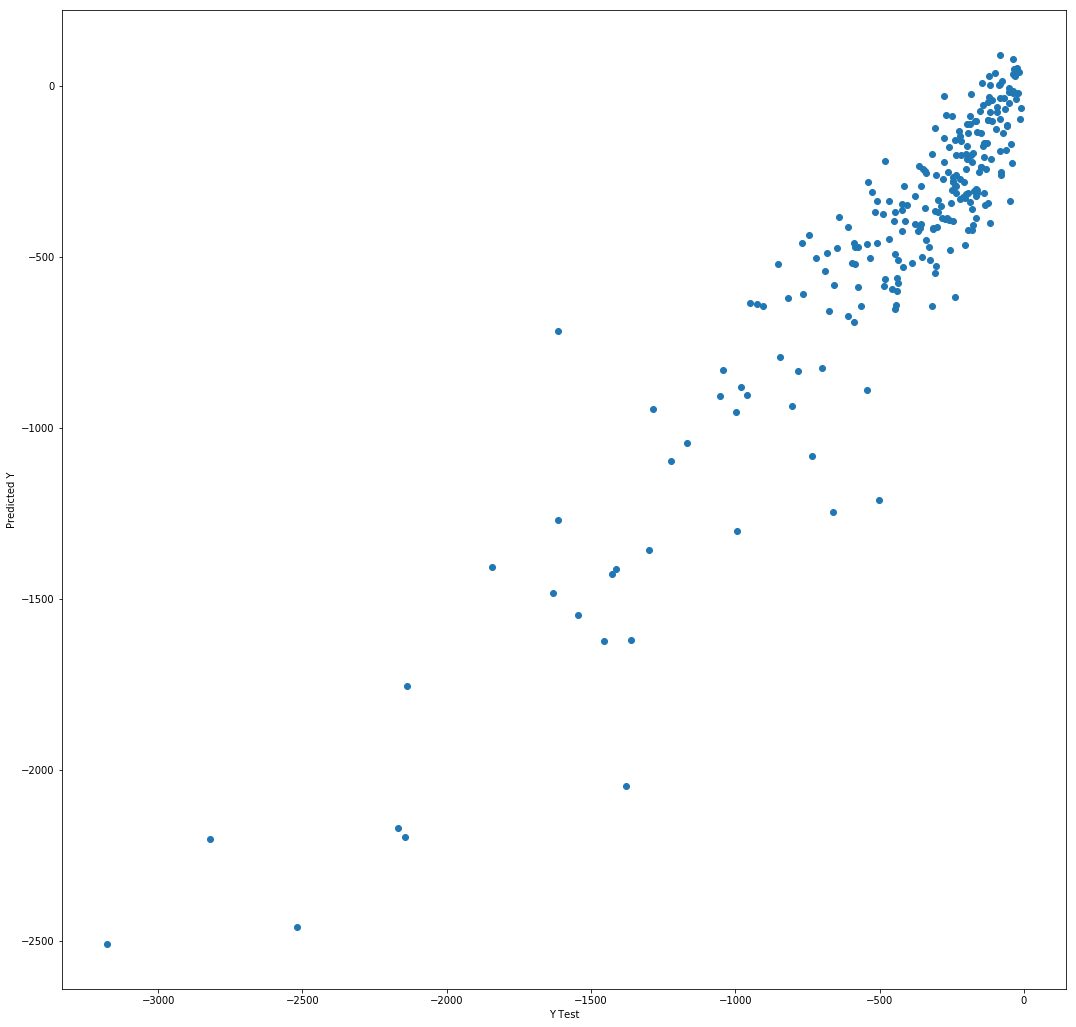

In [48]:
plt.rcParams["figure.figsize"] = (18,18)
plt.scatter(y,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

From the scatter plot above, it can be seen from the strong correlation between y_test and predicated Y that the model works reasonably well.

In [49]:
from sklearn import metrics

print('Mean Absolute Error:    ', '{:.3f}'.format(metrics.mean_absolute_error(y, predictions)))
print('Mean Squard Error:      ', '{:.3f}'.format(metrics.mean_squared_error(y, predictions)))
print('Root Mean Squared Error:', '{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y, predictions))))
print('r-squared:              ', '{:.3f}'.format(metrics.r2_score (y, predictions)))
print('Explained variance      ', '{:.3f}'.format(metrics.explained_variance_score(y, predictions)))

Mean Absolute Error:     126.543
Mean Squard Error:       31551.054
Root Mean Squared Error: 177.626
r-squared:               0.864
Explained variance       0.864


How to improve the model for next time:

1. Use data from the ONS such as data about local adult literacy, local crime rates, etc. 
2. As I write this in 2024, much has changed, some stores have smart fitting room technology, self checkout technology and some are even untagged. If I were to perform this analysis again, I would factor these features into account. 
3. Include data about staff experience. Some stores have a higher turnover rate and as a result, staff are not trained as well. 
4. Rather than predict stockloss, I would use a more normalised measure such as Loss % Sales. 